# Performance Analysis of Image Feature Descriptors with Classical Classification Algorithms
### Dataset -> https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection/data

This notebook implements scikit learn models for binary classification of brain tumor images

Classification Algorithms used : Logistic Regression, Naive Bayes & Support Vector Classifier

The ML models are trained on the following types of data \
i. flattened, normalised image pixels \
ii. SIFT + BoVW  \
iii. HOG

In [1]:
# Importing Libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import sys

In [2]:
# Getting the root directory for easier file access
cwd = os.getcwd()
root_dir = os.path.dirname(cwd)
print(cwd, root_dir, sep="\n")

C:\random\Desktop\ResearchTopics\RS2\notebooks
C:\random\Desktop\ResearchTopics\RS2


In [3]:
# adding the src path to sys.path for accesing functions defines .py files in src folder
src_path = os.path.join(root_dir, 'src') 

# Add the src path to sys.path
sys.path.insert(0, os.path.abspath(src_path)) 

In [4]:
# importing methods defined in src folder

from Extract_Features import extract_flattened_image_vectors 
from Extract_Features import extract_sift_features_from_images
from Extract_Features import kmeans_clustering_sift_descriptors
from Extract_Features import BoVW, extract_hog_features_from_images
from Dataset_Imbalancing import generate_imbalanced_brainTumor_dataset

## Data Loading and Preliminary Analysis

In [7]:
# The dataset is first downloaded locally and then uploaded to the notebook

d1_path = os.path.join(root_dir, r"data\Dataset 1")
_, no_tumor_img_path, _, _, tumor_img_path = [os.path.join(d1_path, path) for path in os.listdir(d1_path)]

# filenames of no_tumor_img_path
no_tumor_img_names = [os.path.join(no_tumor_img_path, path) for path in os.listdir(no_tumor_img_path)]

# filenames of tumor_img_path
tumor_img_names = [os.path.join(tumor_img_path, path) for path in os.listdir(tumor_img_path)]

print("Number of tumor images: ", len(tumor_img_names))
print("Number of no tumor images: ", len(no_tumor_img_names))

Number of tumor images:  1500
Number of no tumor images:  1500


In [8]:
os.listdir(d1_path)

['Br35H-Mask-RCNN', 'no', 'pred', 'Transformations', 'yes']

In [9]:
# creating labels for each images
import re

all_img_df = pd.DataFrame(columns = ["Image Path", "Label"])
all_img_paths = pd.Series(no_tumor_img_names+tumor_img_names)

for i, img in enumerate(all_img_paths):
    img_name = os.path.basename(img)
    label = re.split("[0-9]", img_name)[0]
    all_img_df.loc[i] = {"Image Path" : img, "Label": label}

In [10]:
# it was observed that there are two labels: 'no' & 'No'  for non tumor images -> 'No' is replaced with 'no'
all_img_df['Label'] = all_img_df['Label'].replace('No', 'no')

In [11]:
# numerical encoding of binary labels using label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

all_img_df['Encoded_Labels'] = pd.Series(le.fit_transform(all_img_df["Label"]))

print(all_img_df['Label'].tail(5))
print(all_img_df['Encoded_Labels'].tail(5))

2995    y
2996    y
2997    y
2998    y
2999    y
Name: Label, dtype: object
2995    1
2996    1
2997    1
2998    1
2999    1
Name: Encoded_Labels, dtype: int64


In [12]:
le.classes_

array(['no', 'y'], dtype=object)

In [13]:
# splitting into 2 sets: train (0.8) and test (0.2) set

from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test = tts(all_img_df["Image Path"], all_img_df["Encoded_Labels"], train_size = 0.8, shuffle = True)

# reindexing so that imbalance sampling will be easier
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
print("X Train Shape: ", X_train.shape)
print("Y Train Shape: ", y_train.shape)
print("X Test Shape: ", X_test.shape)
print("Y Test Shape: ", y_test.shape)

X Train Shape:  (2400,)
Y Train Shape:  (2400,)
X Test Shape:  (600,)
Y Test Shape:  (600,)


In [14]:
# Analysing the distribution of tumor and non tumor images in train and test set

train_label_counts = y_train.value_counts()
test_label_counts = y_test.value_counts()

print("Train ", train_label_counts)
print("\nTest ", test_label_counts)

Train  Encoded_Labels
0    1201
1    1199
Name: count, dtype: int64

Test  Encoded_Labels
1    301
0    299
Name: count, dtype: int64


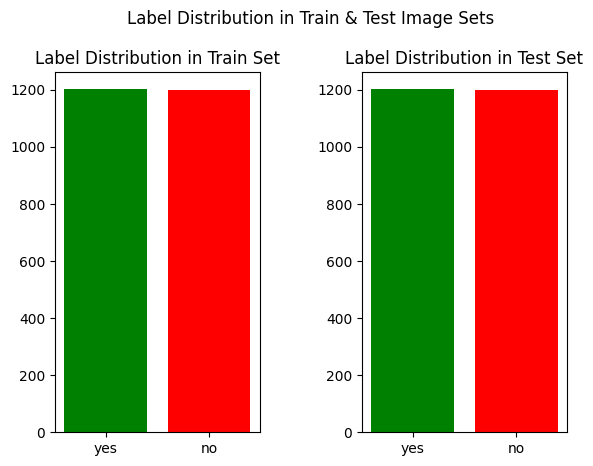

In [15]:
# plotting the distribution

fig, ax = plt.subplots(1, 2)

ax[0].bar(["yes", "no"], list(train_label_counts), color = ["green", "red"])
ax[0].set_title("Label Distribution in Train Set")
ax[1].bar(["yes", "no"], list(train_label_counts), color = ["green", "red"])
ax[1].set_title("Label Distribution in Test Set")

plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.1, wspace=0.5)
plt.suptitle("Label Distribution in Train & Test Image Sets")
plt.savefig(os.path.join(root_dir, r"results\figures\Label Distribution in Train & Test Image Sets.png"), bbox_inches = "tight") 

### Visualising Tumor and Non tumor images

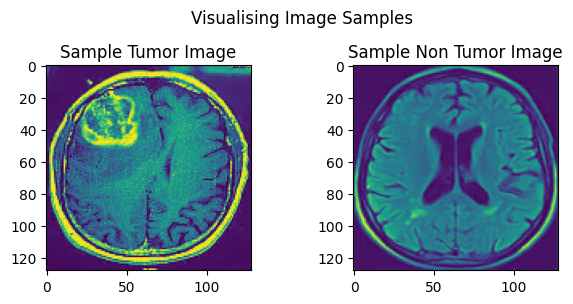

In [16]:
fig, axes = plt.subplots(1, 2)

sample_tumor_img = cv2.resize(cv2.imread(tumor_img_names[250], cv2.IMREAD_GRAYSCALE), (128, 128))
sample_non_tumor_img = cv2.resize(cv2.imread(no_tumor_img_names[506], cv2.IMREAD_GRAYSCALE), (128, 128))

axes[0].imshow(sample_tumor_img)
axes[0].set_title("Sample Tumor Image")

axes[1].imshow(sample_non_tumor_img)
axes[1].set_title("Sample Non Tumor Image")

plt.subplots_adjust(left=0.1, right=0.9, top=1.2, bottom=0.1, wspace=0.5)
plt.suptitle("Visualising Image Samples")
plt.savefig(os.path.join(root_dir, r"results\figures\Brain_Tumor_Image_Samples.png"), bbox_inches = "tight") 

## Step 1 -> Flatten the images and normalise the vector 

In [17]:
X_train_img_vectors = []
X_test_img_vectors = []

X_train_img_vectors = extract_flattened_image_vectors(X_train)
print("Train image vectors extracted successfully")
X_test_img_vectors = extract_flattened_image_vectors(X_test)
print("Test image vectors extracted successfully")

Train image vectors extracted successfully
Test image vectors extracted successfully


In [18]:
# converting the vector lists to dataframes

X_train_img_vectors_df = pd.DataFrame(X_train_img_vectors)
X_test_img_vectors_df = pd.DataFrame(X_test_img_vectors)

print("Shape of X Train Image Vectors : ", X_train_img_vectors_df.shape)
print("Shape of X Test Image Vectors : ", X_test_img_vectors_df.shape)

Shape of X Train Image Vectors :  (2400, 16384)
Shape of X Test Image Vectors :  (600, 16384)


## Step 2 -> SIFT + K-means Clustering + BoVW

#### Training Process

1. Extract SIFT descriptors from each image in the training dataset
2. Then create a pool of all these descriptors
3. Using this pool, fit K-means clustering algorithm for k = 500
4. Using the fitted K-means estimator and image descriptors, Create a histogram of k-vectors for each image based on the closeness of each descriptor from a particular cluster.
5. Now, three sets of SIFT+Kmeans+BoVW for k = 500 can be used in image classification.

#### For Test Set/New Data:

1. Extract SIFT descriptors for each image in test set or for the new data
2. Using the fitted K-means estimator and image descriptors, Create a histogram of k-vectors for each image based on the closeness of each descriptor from a particular cluster.
3. Use the k-element histogram for image classification


In [19]:
# Sample EXtracted SIFT for sample image

sample_tumor_img = cv2.resize(cv2.imread(tumor_img_names[250], cv2.IMREAD_GRAYSCALE), (128, 128))
sample_non_tumor_img = cv2.resize(cv2.imread(no_tumor_img_names[506], cv2.IMREAD_GRAYSCALE), (128, 128))

sift = cv2.SIFT_create()

tumor_keypoints, tumor_descriptors = sift.detectAndCompute(sample_tumor_img, None)
non_tumor_keypoints, non_tumor_descriptors = sift.detectAndCompute(sample_non_tumor_img, None)

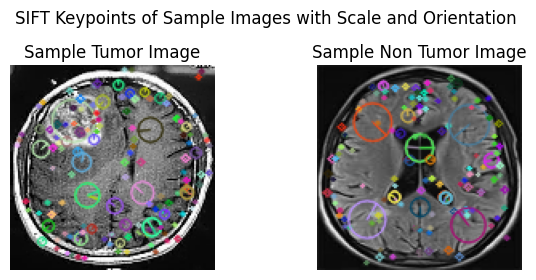

In [20]:
tumor_img_with_keypoints = cv2.drawKeypoints(
    image=sample_tumor_img,  # Original image (or its copy)
    keypoints=tumor_keypoints,
    outImage=None, # Output image (will be created automatically if None)
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS # This is the magic flag!
)

non_tumor_img_with_keypoints = cv2.drawKeypoints(
    image=sample_non_tumor_img,  # Original image (or its copy)
    keypoints=non_tumor_keypoints,
    outImage=None, # Output image (will be created automatically if None)
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS # This is the magic flag!
)

# Display the image
fig, ax = plt.subplots(1, 2)
#ax[0].imshow(cv2.cvtColor(tumor_img_with_keypoints, cv2.COLOR_BGR2RGB)) 
ax[0].imshow(tumor_img_with_keypoints) 
ax[0].set_title("Sample Tumor Image")
ax[0].set_axis_off()
#ax[1].imshow(cv2.cvtColor(non_tumor_img_with_keypoints, cv2.COLOR_BGR2RGB)) 
ax[1].imshow(non_tumor_img_with_keypoints) 
ax[1].set_title("Sample Non Tumor Image")
ax[1].set_axis_off()

plt.subplots_adjust(left=0.1, right=0.9, top=1.2, bottom=0.1, wspace=0.5)
plt.suptitle("SIFT Keypoints of Sample Images with Scale and Orientation")
plt.savefig(os.path.join(root_dir, r"results\figures\SIFT Keypoints of Sample Images with Scale and Orientation.png"), bbox_inches = "tight") 
plt.show()

In [21]:
# extracting features for train set only and forming a descriptor library for BoVW
train_image_sift_descriptors_list = extract_sift_features_from_images(X_train)

print(len(train_image_sift_descriptors_list))
print(len(train_image_sift_descriptors_list[0]))


2400
200


In [22]:
# fitting kmeans clustering algorithm from sklearn.cluster
k = 500
kmeans_estimator_500 = kmeans_clustering_sift_descriptors(train_image_sift_descriptors_list, k)

Pooling sift descriptors successful.
Total number of sift descriptors in the pool:  303219


In [23]:
# the following numpy arrays is used for training models

kmeans_500_train_image_histogram_of_visual_words = BoVW(kmeans_estimator_500, k, train_image_sift_descriptors_list)

In [24]:
# Extracting sift features from the test set and creating Histogram of visual words

test_image_sift_descriptors_list = extract_sift_features_from_images(X_test)

print(len(test_image_sift_descriptors_list))
print(len(test_image_sift_descriptors_list[0]))

kmeans_500_test_image_histogram_of_visual_words = BoVW(kmeans_estimator_500, k, test_image_sift_descriptors_list)


600
106


## HOG Features

The Scikit-image library is used to extract the hog features as 1D vector.

The hog is configured as per the original paper.
orientation bins = 9
pixels per cell = (8,8)
cells per block = (2, 2)

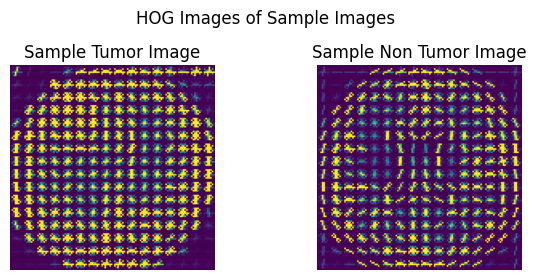

In [25]:
# visualising sample hog descriptor for tumor and non tumor images
from skimage.feature import hog
from skimage import exposure

sample_tumor_img = cv2.resize(cv2.imread(tumor_img_names[250], cv2.IMREAD_GRAYSCALE), (128, 128))
sample_non_tumor_img = cv2.resize(cv2.imread(no_tumor_img_names[506], cv2.IMREAD_GRAYSCALE), (128, 128))

_, hog_img_sample_tumor_img = hog(sample_tumor_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize = True)
_, hog_img_sample_non_tumor_img = hog(sample_non_tumor_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize = True)

# rescaling for better visualization
hog_img_sample_tumor_img_rescaled = exposure.rescale_intensity(hog_img_sample_tumor_img, in_range=(0, 10))
hog_img_sample_non_tumor_img_rescaled = exposure.rescale_intensity(hog_img_sample_non_tumor_img, in_range=(0, 10))

# Display the image
fig, ax = plt.subplots(1, 2)
#ax[0].imshow(cv2.cvtColor(tumor_img_with_keypoints, cv2.COLOR_BGR2RGB)) 
ax[0].imshow(hog_img_sample_tumor_img_rescaled) 
ax[0].set_title("Sample Tumor Image")
ax[0].set_axis_off()
#ax[1].imshow(cv2.cvtColor(non_tumor_img_with_keypoints, cv2.COLOR_BGR2RGB)) 
ax[1].imshow(hog_img_sample_non_tumor_img_rescaled) 
ax[1].set_title("Sample Non Tumor Image")
ax[1].set_axis_off()

plt.subplots_adjust(left=0.1, right=0.9, top=1.2, bottom=0.1, wspace=0.5)
plt.suptitle("HOG Images of Sample Images")
plt.savefig(os.path.join(root_dir, r"results\figures\HOG Images of Sample Images.png"), bbox_inches = "tight") 
plt.show()

In [26]:
train_image_hog_descriptors_list = extract_hog_features_from_images(X_train)
test_image_hog_descriptors_list = extract_hog_features_from_images(X_test)

In [27]:
train_image_hog_descriptors_list = np.array(train_image_hog_descriptors_list)
test_image_hog_descriptors_list = np.array(test_image_hog_descriptors_list)

print("Shape of HOG descriptors in training image set : ",  train_image_hog_descriptors_list.shape)
print("Shape of HOG descriptors in testing image set : ",  test_image_hog_descriptors_list.shape)  

Shape of HOG descriptors in training image set :  (2400, 8100)
Shape of HOG descriptors in testing image set :  (600, 8100)


## Model Development & Training
All the models used are from scikit-learn
1. Logistic Regression
2. Naive Bayes
3. Support Vector Machine

The models are developed under 3 categories:
1. Raw Normalised Image Vectors
2. SIFT+K-Means Clustering+BoVW Histogram Vectors
3. HOG Histogram Vectors

Evaluation Metrics

### Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

#### Raw Normalised Image Vectors as input

In [29]:
# initialise LogisticRegression()
raw_norm_img_vector_LR = LogisticRegression()

# fit the initialised LogisticRegression()
raw_norm_img_vector_LR = raw_norm_img_vector_LR.fit(X_train_img_vectors_df, y_train)

# predict for test set
raw_norm_img_vector_LR_y_predicted = raw_norm_img_vector_LR.predict(X_test_img_vectors_df)

# generate the classification report
raw_norm_img_vector_LR_report = classification_report(y_test, raw_norm_img_vector_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])

print(raw_norm_img_vector_LR_report)

              precision    recall  f1-score   support

   Non Tumor       0.97      0.97      0.97       299
       Tumor       0.97      0.97      0.97       301

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



#### BoVW Vectors generated from SIFT Descriptors as input

In [30]:
# initialise LogisticRegression()
SIFT_Kmeans500_BoVW_LR = LogisticRegression()

# fit the initialised LogisticRegression()
SIFT_Kmeans500_BoVW_LR = SIFT_Kmeans500_BoVW_LR.fit(kmeans_500_train_image_histogram_of_visual_words, y_train)

# predict for test set
SIFT_Kmeans500_BoVW_LR_y_predicted = SIFT_Kmeans500_BoVW_LR.predict(kmeans_500_test_image_histogram_of_visual_words)

# generate the classification report
SIFT_Kmeans500_BoVW_LR_report = classification_report(y_test, SIFT_Kmeans500_BoVW_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])

print(SIFT_Kmeans500_BoVW_LR_report)

              precision    recall  f1-score   support

   Non Tumor       0.92      0.93      0.92       299
       Tumor       0.93      0.92      0.92       301

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600



#### HOG Descriptors as input

In [31]:
# initialise LogisticRegression()
HOG_LR = LogisticRegression()

# fit the initialised LogisticRegression()
HOG_LR = HOG_LR.fit(train_image_hog_descriptors_list, y_train)

# predict for test set
HOG_LR_y_predicted = HOG_LR.predict(test_image_hog_descriptors_list)

# generate the classification report
HOG_LR_report = classification_report(y_test, HOG_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])

print(HOG_LR_report)

              precision    recall  f1-score   support

   Non Tumor       0.97      0.98      0.98       299
       Tumor       0.98      0.97      0.98       301

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



##### Observations

1. The Logistic Regression Model with raw pixel values performed better than expected
2. SIFT+BoVW performed the least -> possibly due to loss of information during keypoint extraction or histogram population
3. HOG features performed on par with the raw pixel features.

#### Naive Bayes

In [32]:
from sklearn.naive_bayes import GaussianNB

#### Raw Normalised Image Vectors as input

In [33]:
# initialise LogisticRegression()
raw_norm_img_vector_NB = GaussianNB()

# fit the initialised LogisticRegression()
raw_norm_img_vector_NB = raw_norm_img_vector_NB.fit(X_train_img_vectors_df, y_train)

# predict for test set
raw_norm_img_vector_NB_y_predicted = raw_norm_img_vector_NB.predict(X_test_img_vectors_df)

# generate the classification report
raw_norm_img_vector_NB_report = classification_report(y_test, raw_norm_img_vector_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])

print(raw_norm_img_vector_NB_report)

              precision    recall  f1-score   support

   Non Tumor       0.64      0.79      0.71       299
       Tumor       0.73      0.56      0.64       301

    accuracy                           0.68       600
   macro avg       0.69      0.68      0.67       600
weighted avg       0.69      0.68      0.67       600



#### BoVW Vectors generated from SIFT Descriptors as input

In [34]:
# initialise LogisticRegression()
SIFT_Kmeans500_BoVW_NB = GaussianNB()

# fit the initialised LogisticRegression()
SIFT_Kmeans500_BoVW_NB = SIFT_Kmeans500_BoVW_NB.fit(kmeans_500_train_image_histogram_of_visual_words, y_train)

# predict for test set
SIFT_Kmeans500_BoVW_NB_y_predicted = SIFT_Kmeans500_BoVW_NB.predict(kmeans_500_test_image_histogram_of_visual_words)

# generate the classification report
SIFT_Kmeans500_BoVW_NB_report = classification_report(y_test, SIFT_Kmeans500_BoVW_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])

print(SIFT_Kmeans500_BoVW_NB_report)

              precision    recall  f1-score   support

   Non Tumor       0.90      0.75      0.82       299
       Tumor       0.79      0.91      0.84       301

    accuracy                           0.83       600
   macro avg       0.84      0.83      0.83       600
weighted avg       0.84      0.83      0.83       600



#### HOG Descriptors as input

In [35]:
# initialise LogisticRegression()
HOG_NB = GaussianNB()

# fit the initialised LogisticRegression()
HOG_NB = HOG_NB.fit(train_image_hog_descriptors_list, y_train)

# predict for test set
HOG_NB_y_predicted = HOG_NB.predict(test_image_hog_descriptors_list)

# generate the classification report
HOG_NB_report = classification_report(y_test, HOG_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])

print(HOG_NB_report)

              precision    recall  f1-score   support

   Non Tumor       0.80      0.63      0.71       299
       Tumor       0.70      0.85      0.77       301

    accuracy                           0.74       600
   macro avg       0.75      0.74      0.74       600
weighted avg       0.75      0.74      0.74       600



##### Observations

1. As opposed to that of Logistic Regression, raw pixel features performed the worst with naive bayes classifier
2. As opposed to that of Logistic Regression, SIFT+BoVW performed the best
3. HOG features performed decently.

#### Support Vector Machine

In [36]:
from sklearn.svm import LinearSVC

#### Raw Normalised Image Vectors as input

In [37]:
# initialise LogisticRegression()
raw_norm_img_vector_SVC = LinearSVC()

# fit the initialised LogisticRegression()
raw_norm_img_vector_SVC = raw_norm_img_vector_SVC.fit(X_train_img_vectors_df, y_train)

# predict for test set
raw_norm_img_vector_SVC_y_predicted = raw_norm_img_vector_SVC.predict(X_test_img_vectors_df)

# generate the classification report
raw_norm_img_vector_SVC_report = classification_report(y_test, raw_norm_img_vector_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])

print(raw_norm_img_vector_SVC_report)

c:\random\Desktop\ResearchTopics\RS2\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

   Non Tumor       0.97      0.97      0.97       299
       Tumor       0.97      0.97      0.97       301

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



#### BoVW Vectors generated from SIFT Descriptors as input

In [38]:
# initialise LogisticRegression()
SIFT_Kmeans500_BoVW_SVC = LinearSVC()

# fit the initialised LogisticRegression()
SIFT_Kmeans500_BoVW_SVC = SIFT_Kmeans500_BoVW_SVC.fit(kmeans_500_train_image_histogram_of_visual_words, y_train)

# predict for test set
SIFT_Kmeans500_BoVW_SVC_y_predicted = SIFT_Kmeans500_BoVW_SVC.predict(kmeans_500_test_image_histogram_of_visual_words)

# generate the classification report
SIFT_Kmeans500_BoVW_SVC_report = classification_report(y_test, SIFT_Kmeans500_BoVW_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])

print(SIFT_Kmeans500_BoVW_SVC_report)

              precision    recall  f1-score   support

   Non Tumor       0.90      0.90      0.90       299
       Tumor       0.90      0.90      0.90       301

    accuracy                           0.90       600
   macro avg       0.90      0.90      0.90       600
weighted avg       0.90      0.90      0.90       600



#### HOG Descriptors as input

In [39]:
# initialise LogisticRegression()
HOG_SVC = LinearSVC()

# fit the initialised LogisticRegression()
HOG_SVC = HOG_SVC.fit(train_image_hog_descriptors_list, y_train)

# predict for test set
HOG_SVC_y_predicted_train = HOG_SVC.predict(train_image_hog_descriptors_list)
HOG_SVC_y_predicted_test = HOG_SVC.predict(test_image_hog_descriptors_list)

# generate the classification report
HOG_SVC_report_train = classification_report(y_train, HOG_SVC_y_predicted_train, target_names=['Non Tumor', 'Tumor'])
HOG_SVC_report_test = classification_report(y_test, HOG_SVC_y_predicted_test, target_names=['Non Tumor', 'Tumor'])

print("Train Set:\n", HOG_SVC_report_train)
print("\nTest Set:\n", HOG_SVC_report_test)

Train Set:
               precision    recall  f1-score   support

   Non Tumor       1.00      1.00      1.00      1201
       Tumor       1.00      1.00      1.00      1199

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400


Test Set:
               precision    recall  f1-score   support

   Non Tumor       0.97      0.99      0.98       299
       Tumor       0.99      0.97      0.98       301

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



##### Observations 

The results obtained are similar to that of Logistic Regression

### Interpretations & Further Exploration

The initial data exploration revealed that the dataset was inherently balanced and hence the train & test sets reflected similar balance.

The HOG features based models seem to perform better across different models, so far.

### As a further exploration, the ratio of majority:minority is used to sample train set to better understand the performance of different features in imbalanced datasets 

In the following section, we will experiment with the following ratios (majority:minority): \
i. 3:1 (33% minority) \
ii. 4:1 (25% minority) \
iii. 10:1 (10% minority) \
iv. 100:1 (1% minority) 

#### Sampling all the input datasets

In [40]:
X_train_img_vectors_df_sample_1, y_train_img_vectors_sample_1 = generate_imbalanced_brainTumor_dataset(X_train_img_vectors_df, y_train, 0.33)
X_train_img_vectors_df_sample_2, y_train_img_vectors_sample_2 = generate_imbalanced_brainTumor_dataset(X_train_img_vectors_df, y_train, 0.25)
X_train_img_vectors_df_sample_3, y_train_img_vectors_sample_3 = generate_imbalanced_brainTumor_dataset(X_train_img_vectors_df, y_train, 0.10)
X_train_img_vectors_df_sample_4, y_train_img_vectors_sample_4 = generate_imbalanced_brainTumor_dataset(X_train_img_vectors_df, y_train, 0.01)

In [41]:
sift_bovw_df_sample_1, y_train_sift_bovw_sample_1 = generate_imbalanced_brainTumor_dataset(kmeans_500_train_image_histogram_of_visual_words, y_train, 0.33)
sift_bovw_df_sample_2, y_train_sift_bovw_sample_2 = generate_imbalanced_brainTumor_dataset(kmeans_500_train_image_histogram_of_visual_words, y_train, 0.25)
sift_bovw_df_sample_3, y_train_sift_bovw_sample_3 = generate_imbalanced_brainTumor_dataset(kmeans_500_train_image_histogram_of_visual_words, y_train, 0.10)
sift_bovw_df_sample_4, y_train_sift_bovw_sample_4 = generate_imbalanced_brainTumor_dataset(kmeans_500_train_image_histogram_of_visual_words, y_train, 0.01)

In [42]:
hog_df_sample_1, y_train_hog_sample_1 = generate_imbalanced_brainTumor_dataset(train_image_hog_descriptors_list, y_train, 0.33)
hog_df_sample_2, y_train_hog_sample_2 = generate_imbalanced_brainTumor_dataset(train_image_hog_descriptors_list, y_train, 0.25)
hog_df_sample_3, y_train_hog_sample_3 = generate_imbalanced_brainTumor_dataset(train_image_hog_descriptors_list, y_train, 0.10)
hog_df_sample_4, y_train_hog_sample_4 = generate_imbalanced_brainTumor_dataset(train_image_hog_descriptors_list, y_train, 0.01)

### Model Development & Training on Sampled Datasets

#### Logistic Regression

##### Raw Flattened normalised image data

In [43]:
# Sample 1 - Minority percentage = 33%
# initialise LogisticRegression()
img_vectors_df_sample_1_LR = LogisticRegression()

# fit the initialised LogisticRegression()
img_vectors_df_sample_1_LR = img_vectors_df_sample_1_LR.fit(X_train_img_vectors_df_sample_1, y_train_img_vectors_sample_1)

# predict for test set
img_vectors_df_sample_1_LR_y_predicted = img_vectors_df_sample_1_LR.predict(X_test_img_vectors_df)

# generate the classification report
img_vectors_df_sample_1_LR_report = classification_report(y_test, img_vectors_df_sample_1_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])

print(img_vectors_df_sample_1_LR_report)

c:\random\Desktop\ResearchTopics\RS2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

   Non Tumor       0.91      0.98      0.94       299
       Tumor       0.98      0.90      0.94       301

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



In [44]:
# Sample 2 - Minority percentage = 25%
# initialise LogisticRegression()
img_vectors_df_sample_2_LR = LogisticRegression(max_iter=200)

# fit the initialised LogisticRegression()
img_vectors_df_sample_2_LR = img_vectors_df_sample_2_LR.fit(X_train_img_vectors_df_sample_2, y_train_img_vectors_sample_2)

# predict for test set
img_vectors_df_sample_2_LR_y_predicted = img_vectors_df_sample_2_LR.predict(X_test_img_vectors_df)

# generate the classification report
img_vectors_df_sample_2_LR_report = classification_report(y_test, img_vectors_df_sample_2_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])

print(img_vectors_df_sample_2_LR_report)

              precision    recall  f1-score   support

   Non Tumor       0.84      0.99      0.91       299
       Tumor       0.98      0.81      0.89       301

    accuracy                           0.90       600
   macro avg       0.91      0.90      0.90       600
weighted avg       0.91      0.90      0.90       600



In [45]:
# Sample 3 - Minority percentage = 10%
# initialise LogisticRegression()
img_vectors_df_sample_3_LR = LogisticRegression()

# fit the initialised LogisticRegression()
img_vectors_df_sample_3_LR = img_vectors_df_sample_3_LR.fit(X_train_img_vectors_df_sample_3, y_train_img_vectors_sample_3)

# predict for test set
img_vectors_df_sample_3_LR_y_predicted = img_vectors_df_sample_3_LR.predict(X_test_img_vectors_df)

# generate the classification report
img_vectors_df_sample_3_LR_report = classification_report(y_test, img_vectors_df_sample_3_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])

print(img_vectors_df_sample_3_LR_report)

c:\random\Desktop\ResearchTopics\RS2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

   Non Tumor       0.65      0.99      0.78       299
       Tumor       0.99      0.46      0.63       301

    accuracy                           0.72       600
   macro avg       0.82      0.73      0.70       600
weighted avg       0.82      0.72      0.70       600



In [46]:
# Sample 4 - Minority percentage = 1%
# initialise LogisticRegression()
img_vectors_df_sample_4_LR = LogisticRegression()

# fit the initialised LogisticRegression()
img_vectors_df_sample_4_LR = img_vectors_df_sample_4_LR.fit(X_train_img_vectors_df_sample_4, y_train_img_vectors_sample_4)

# predict for test set
img_vectors_df_sample_4_LR_y_predicted = img_vectors_df_sample_4_LR.predict(X_test_img_vectors_df)

# generate the classification report
img_vectors_df_sample_4_LR_report = classification_report(y_test, img_vectors_df_sample_4_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])

print(img_vectors_df_sample_4_LR_report)

              precision    recall  f1-score   support

   Non Tumor       0.52      1.00      0.68       299
       Tumor       1.00      0.08      0.14       301

    accuracy                           0.54       600
   macro avg       0.76      0.54      0.41       600
weighted avg       0.76      0.54      0.41       600



##### SIFT+KMeans+BoVW


In [47]:
# Sample 1 - Minority percentage = 33%
# initialise LogisticRegression()
sift_bovw_df_sample_1_LR = LogisticRegression()

# fit the initialised LogisticRegression()
sift_bovw_df_sample_1_LR = sift_bovw_df_sample_1_LR.fit(sift_bovw_df_sample_1, y_train_sift_bovw_sample_1)

# predict for test set
sift_bovw_df_sample_1_LR_y_predicted = sift_bovw_df_sample_1_LR.predict(kmeans_500_test_image_histogram_of_visual_words)

# generate the classification report
sift_bovw_df_sample_1_LR_report = classification_report(y_test, sift_bovw_df_sample_1_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])

print(sift_bovw_df_sample_1_LR_report)

              precision    recall  f1-score   support

   Non Tumor       0.89      0.93      0.91       299
       Tumor       0.93      0.88      0.90       301

    accuracy                           0.91       600
   macro avg       0.91      0.91      0.91       600
weighted avg       0.91      0.91      0.91       600



In [48]:
# Sample 2 - Minority percentage = 25%
# initialise LogisticRegression()
sift_bovw_df_sample_2_LR = LogisticRegression()

# fit the initialised LogisticRegression()
sift_bovw_df_sample_2_LR = sift_bovw_df_sample_2_LR.fit(sift_bovw_df_sample_2, y_train_sift_bovw_sample_2)

# predict for test set
sift_bovw_df_sample_2_LR_y_predicted = sift_bovw_df_sample_2_LR.predict(kmeans_500_test_image_histogram_of_visual_words)

# generate the classification report
sift_bovw_df_sample_2_LR_report = classification_report(y_test, sift_bovw_df_sample_2_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])

print(sift_bovw_df_sample_2_LR_report)

              precision    recall  f1-score   support

   Non Tumor       0.85      0.96      0.90       299
       Tumor       0.95      0.84      0.89       301

    accuracy                           0.90       600
   macro avg       0.90      0.90      0.90       600
weighted avg       0.90      0.90      0.90       600



# Wrong Exploration and Interpretation of the previous (before sampling) model performance results

I conveniently assumed that the model behavior/performance was bad especially in SIFT+BoVW inputs was due to the balanced nature of the dataset. 
But the logistic regression training phase post sampling for all the three kinds of datasets, I still found that the SIFT+BoVW was performing worse than the raw pixels. So, then the question was why is SIFT+BoVW performing poorly ? Because it is a model developed to perform better than the raw images. \
Thats when it clicked me, feature descriptors are not developed primarily to work well with imbalanced data, but rather they are developed to be indifferent to image transformations like scaling, rotations and so on. And this was in the name SIFT itself (Scale Invariant Feature Transformations). \
So the reason why models trained before sampling performed that way is because there was no image transformations affecting it. all of the images had the same kind of structure only. So it is obvious for the raw images to work better. 

With this understanding, the actual way to clearly analyze feature descriptors is by introducing diverse image transformations in the dataset. 
By augmenting the dataset with image transformations, we will be able to analyze the significance of the descriptors better.

#### Because there is pivot in research direction, the following experimentation will be done in PyTorch for easier augmentation.

# Revised Research Goals

Here we examine how the model becomes more robust to diverse transformations when trained on feature descriptors.

So we do this exploration in three phases:

###### Phase 1: We train models on untransformed data, but test on augmented transform data. 
-> this phase focuses on how feature descriptors like SIFT and HOG help in classifying transformed data even when trained on untransformed data.  
###### Phase 2: We train models on augmented transformed data and test on augmented transfored data. 
-> this phase focuses on how augmentation in both train and test sets can improve model performance when using feature descriptors 
###### Phase 3: We further define a simple CNN  model and understand how classification metrics improve when combined with feature descriptors 
-> this phase considers the dataset used in phase 2 for model development and evaluation 

#### Here we will use PyTorch for augmentation and CNN only. 

## Augmentation 

The 5 types of transformations is tested here. \
i. Rotation of images (rotation - 15 deg, 30 deg, 45 deg & 60 deg)  \
ii. Scaling of images (scaling - 80%, 60% & 40%) \
iii. Gaussian Blurring of images (gblur - 3x3 kernel, 5x5 kernel) \
iv. Addition of Noise to images (gnoise) \
v. Random Combination of the above 4 transformations (mixed) 

For the phase 1, the train-test split initially performed is used. The transformations is introduced in test set only. 

In [49]:
import torch
from torchvision import transforms
from PIL import Image
torch.manual_seed(17)

In [50]:
def transform_and_extract(X, y, transformation, folder_path, include_original = False):

    # labels for the randomly selected images
    transform_images = []
    transform_labels = y.copy()

    for i, path in X.items():
        label = y[i]
        img_path = os.path.join(folder_path, f'{label}_img_{i}.jpg')
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        transformed_img = transformation(img)
        transformed_img.save(img_path)
        

#### Rotation

In [51]:
transform_rotation_15 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15)
])
folder_path = os.path.join(root_dir, r'data\Dataset 1\Transformations\rotated_test\deg_15')
transform_and_extract(X_test, y_test, transform_rotation_15, folder_path)

In [52]:
transform_rotation_30 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(30)
])
folder_path = os.path.join(root_dir, r'data\Dataset 1\Transformations\rotated_test\deg_30')
transform_and_extract(X_test, y_test, transform_rotation_30, folder_path)

In [53]:
transform_rotation_45 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(45)
])
folder_path = os.path.join(root_dir, r'data\Dataset 1\Transformations\rotated_test\deg_45')
transform_and_extract(X_test, y_test, transform_rotation_45, folder_path)

In [54]:
transform_rotation_60 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(60)
])
folder_path = os.path.join(root_dir, r'data\Dataset 1\Transformations\rotated_test\deg_60')
transform_and_extract(X_test, y_test, transform_rotation_60, folder_path)

#### Scaling

In [55]:
# custom scaling class because we are scaling by particular factor

class ScaleByPercent(object):
    def __init__(self, percent):
        self.percent = percent

    def __call__(self, img):
        if not isinstance(img, Image.Image):
            raise TypeError("Input must be a PIL Image.")

        width, height = img.size
        new_width = int(width * self.percent / 100)
        new_height = int(height * self.percent / 100)
        
        return transforms.functional.resize(img, (new_height, new_width))


In [56]:
transform_scaling_80 = transforms.Compose([
    transforms.ToPILImage(),
    ScaleByPercent(80)
])
folder_path = os.path.join(root_dir, r'data\Dataset 1\Transformations\scaled_test\scaled_80_percent')
transform_and_extract(X_test, y_test, transform_scaling_80, folder_path)

In [57]:
transform_scaling_60 = transforms.Compose([
    transforms.ToPILImage(),
    ScaleByPercent(60)
])
folder_path = os.path.join(root_dir, r'data\Dataset 1\Transformations\scaled_test\scaled_60_percent')
transform_and_extract(X_test, y_test, transform_scaling_60, folder_path)

In [58]:
transform_scaling_40 = transforms.Compose([
    transforms.ToPILImage(),
    ScaleByPercent(40)
])
folder_path = os.path.join(root_dir, r'data\Dataset 1\Transformations\scaled_test\scaled_40_percent')
transform_and_extract(X_test, y_test, transform_scaling_40, folder_path)

#### Gaussian Blurring

In [59]:
transform_gblur_3 = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.GaussianBlur(3, 1.5)
])
folder_path = os.path.join(root_dir, r'data\Dataset 1\Transformations\gblurred_test\gblur_kernel3')
transform_and_extract(X_test, y_test, transform_gblur_3, folder_path)

In [60]:
transform_gblur_5 = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.GaussianBlur(5, 1.5)
])
folder_path = os.path.join(root_dir, r'data\Dataset 1\Transformations\gblurred_test\gblur_kernel5')
transform_and_extract(X_test, y_test, transform_gblur_5, folder_path)

#### Gaussian Noise

In [61]:
class AddGaussianNoise(object):
    """
    Adds Gaussian noise to a PIL Image.
    
    Args:
        mean (float): The mean of the Gaussian distribution.
        std_dev (float): The standard deviation of the Gaussian distribution.
    """
    def __init__(self, mean=0.0, std_dev=15.0):
        self.mean = mean
        self.std_dev = std_dev

    def __call__(self, img):
        if not isinstance(img, Image.Image):
            raise TypeError("Input must be a PIL Image.")

        # Convert the PIL image to a NumPy array
        img_np = np.array(img, dtype=np.float32)

        # Generate a random Gaussian noise array
        noise = np.random.normal(self.mean, self.std_dev, img_np.shape).astype(np.float32)

        # Add the noise to the image
        noisy_img_np = img_np + noise

        # Clip values to stay within the valid range [0, 255]
        noisy_img_np = np.clip(noisy_img_np, 0, 255)

        # Convert the NumPy array back to a PIL Image (and back to uint8)
        return Image.fromarray(noisy_img_np.astype(np.uint8))



#### Gaussian noise

In [62]:
transform_gnoise = transforms.Compose([
    transforms.ToPILImage(), 
    AddGaussianNoise(mean=0.0, std_dev=20.0)
])
folder_path = os.path.join(root_dir, r'data\Dataset 1\Transformations\gnoised_test')
transform_and_extract(X_test, y_test, transform_gnoise, folder_path)


#### Mixed

In [63]:
transform_mixed = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.RandomRotation(45), 
    ScaleByPercent(80), 
    transforms.GaussianBlur(3, 1.5), 
    AddGaussianNoise(mean=0.0, std_dev=20.0)
])
folder_path = os.path.join(root_dir, r'data\Dataset 1\Transformations\mixed_test')
transform_and_extract(X_test, y_test, transform_mixed, folder_path)

#### Transformed X and y for test set

In [64]:
rotated_15_test_path = os.path.join(root_dir, r'data\Dataset 1\Transformations\rotated_test\deg_15')
rotated_15_test_X = pd.Series([os.path.join(rotated_15_test_path, path) for path in os.listdir(rotated_15_test_path)]) 
rotated_15_test_y = pd.Series([int(re.split("[_]", name)[0]) for name in os.listdir(rotated_15_test_path)])

rotated_30_test_path = os.path.join(root_dir, r'data\Dataset 1\Transformations\rotated_test\deg_30')
rotated_30_test_X = pd.Series([os.path.join(rotated_30_test_path, path) for path in os.listdir(rotated_30_test_path)]) 
rotated_30_test_y = pd.Series([int(re.split("[_]", name)[0]) for name in os.listdir(rotated_30_test_path)])

rotated_45_test_path = os.path.join(root_dir, r'data\Dataset 1\Transformations\rotated_test\deg_45')
rotated_45_test_X = pd.Series([os.path.join(rotated_45_test_path, path) for path in os.listdir(rotated_45_test_path)]) 
rotated_45_test_y = pd.Series([int(re.split("[_]", name)[0]) for name in os.listdir(rotated_45_test_path)])

rotated_60_test_path = os.path.join(root_dir, r'data\Dataset 1\Transformations\rotated_test\deg_60')
rotated_60_test_X = pd.Series([os.path.join(rotated_60_test_path, path) for path in os.listdir(rotated_60_test_path)]) 
rotated_60_test_y = pd.Series([int(re.split("[_]", name)[0]) for name in os.listdir(rotated_60_test_path)])

In [65]:
scaled_80_test_path = os.path.join(root_dir, r'data\Dataset 1\Transformations\scaled_test\scaled_80_percent')
scaled_80_test_X = pd.Series([os.path.join(scaled_80_test_path, path) for path in os.listdir(scaled_80_test_path)]) 
scaled_80_test_y = pd.Series([int(re.split("[_]", name)[0]) for name in os.listdir(scaled_80_test_path)])

scaled_60_test_path = os.path.join(root_dir, r'data\Dataset 1\Transformations\scaled_test\scaled_60_percent')
scaled_60_test_X = pd.Series([os.path.join(scaled_60_test_path, path) for path in os.listdir(scaled_60_test_path)]) 
scaled_60_test_y = pd.Series([int(re.split("[_]", name)[0]) for name in os.listdir(scaled_60_test_path)])

scaled_40_test_path = os.path.join(root_dir, r'data\Dataset 1\Transformations\scaled_test\scaled_40_percent')
scaled_40_test_X = pd.Series([os.path.join(scaled_40_test_path, path) for path in os.listdir(scaled_40_test_path)]) 
scaled_40_test_y = pd.Series([int(re.split("[_]", name)[0]) for name in os.listdir(scaled_40_test_path)])


In [66]:
gblur_3_test_path = os.path.join(root_dir, r'data\Dataset 1\Transformations\gblurred_test\gblur_kernel3')
gblur_3_test_X = pd.Series([os.path.join(gblur_3_test_path, path) for path in os.listdir(gblur_3_test_path)]) 
gblur_3_test_y = pd.Series([int(re.split("[_]", name)[0]) for name in os.listdir(gblur_3_test_path)])

gblur_5_test_path = os.path.join(root_dir, r'data\Dataset 1\Transformations\gblurred_test\gblur_kernel5')
gblur_5_test_X = pd.Series([os.path.join(gblur_5_test_path, path) for path in os.listdir(gblur_5_test_path)]) 
gblur_5_test_y = pd.Series([int(re.split("[_]", name)[0]) for name in os.listdir(gblur_5_test_path)])

In [67]:
gnoise_test_path = os.path.join(root_dir, r'data\Dataset 1\Transformations\gnoised_test')
gnoise_test_X = pd.Series([os.path.join(gnoise_test_path, path) for path in os.listdir(gnoise_test_path)]) 
gnoise_test_y = pd.Series([int(re.split("[_]", name)[0]) for name in os.listdir(gnoise_test_path)])

mixed_test_path = os.path.join(root_dir, r'data\Dataset 1\Transformations\mixed_test')
mixed_test_X = pd.Series([os.path.join(mixed_test_path, path) for path in os.listdir(mixed_test_path)]) 
mixed_test_y = pd.Series([int(re.split("[_]", name)[0]) for name in os.listdir(mixed_test_path)])

##### Flattened, Normalised image vector

In [68]:
img_vector_rotated_15_test_X = extract_flattened_image_vectors(rotated_15_test_X)
img_vector_rotated_30_test_X = extract_flattened_image_vectors(rotated_30_test_X)
img_vector_rotated_45_test_X = extract_flattened_image_vectors(rotated_45_test_X)
img_vector_rotated_60_test_X = extract_flattened_image_vectors(rotated_60_test_X)
img_vector_scaled_80_test_X = extract_flattened_image_vectors(scaled_80_test_X)
img_vector_scaled_60_test_X = extract_flattened_image_vectors(scaled_60_test_X)
img_vector_scaled_40_test_X = extract_flattened_image_vectors(scaled_40_test_X)
img_vector_gblur_3_test_X = extract_flattened_image_vectors(gblur_3_test_X)
img_vector_gblur_5_test_X = extract_flattened_image_vectors(gblur_5_test_X)
img_vector_gnoise_test_X = extract_flattened_image_vectors(gnoise_test_X)
img_vector_mixed_test_X = extract_flattened_image_vectors(mixed_test_X)

#### SIFT + KMeans + BoVW

In [69]:
def extract_BoVW(X, kmeans, k):
    image_sift_descriptors_list = extract_sift_features_from_images(X)
    kmeans_500_image_histogram_of_visual_words = BoVW(kmeans, k, image_sift_descriptors_list)
    return kmeans_500_image_histogram_of_visual_words

In [70]:
SIFT_BoVW_rotated_15_test_X = extract_BoVW(rotated_15_test_X, kmeans_estimator_500, 500)
SIFT_BoVW_rotated_30_test_X = extract_BoVW(rotated_30_test_X, kmeans_estimator_500, 500)
SIFT_BoVW_rotated_45_test_X = extract_BoVW(rotated_45_test_X, kmeans_estimator_500, 500)
SIFT_BoVW_rotated_60_test_X = extract_BoVW(rotated_60_test_X, kmeans_estimator_500, 500)
SIFT_BoVW_scaled_80_test_X = extract_BoVW(scaled_80_test_X, kmeans_estimator_500, 500)
SIFT_BoVW_scaled_60_test_X = extract_BoVW(scaled_60_test_X, kmeans_estimator_500, 500)
SIFT_BoVW_scaled_40_test_X = extract_BoVW(scaled_40_test_X, kmeans_estimator_500, 500)
SIFT_BoVW_gblur_3_test_X = extract_BoVW(gblur_3_test_X, kmeans_estimator_500, 500)
SIFT_BoVW_gblur_5_test_X = extract_BoVW(gblur_5_test_X, kmeans_estimator_500, 500)
SIFT_BoVW_gnoise_test_X = extract_BoVW(gnoise_test_X, kmeans_estimator_500, 500)
SIFT_BoVW_mixed_test_X = extract_BoVW(mixed_test_X, kmeans_estimator_500, 500)

#### HOG

In [71]:
HOG_rotated_15_test_X = extract_hog_features_from_images(rotated_15_test_X)
HOG_rotated_30_test_X = extract_hog_features_from_images(rotated_30_test_X)
HOG_rotated_45_test_X = extract_hog_features_from_images(rotated_45_test_X)
HOG_rotated_60_test_X = extract_hog_features_from_images(rotated_60_test_X)
HOG_scaled_80_test_X = extract_hog_features_from_images(scaled_80_test_X)
HOG_scaled_60_test_X = extract_hog_features_from_images(scaled_60_test_X)
HOG_scaled_40_test_X = extract_hog_features_from_images(scaled_40_test_X)
HOG_gblur_3_test_X = extract_hog_features_from_images(gblur_3_test_X)
HOG_gblur_5_test_X = extract_hog_features_from_images(gblur_5_test_X)
HOG_gnoise_test_X = extract_hog_features_from_images(gnoise_test_X)
HOG_mixed_test_X = extract_hog_features_from_images(mixed_test_X)

### Evaluation of the LR, NB and SVM classifiers trained on untransformed train datasets

#### Logistic Regression

In [72]:
# predict for transformed test sets
img_vector_rotated_15_LR_y_predicted = raw_norm_img_vector_LR.predict(img_vector_rotated_15_test_X)
img_vector_rotated_30_LR_y_predicted = raw_norm_img_vector_LR.predict(img_vector_rotated_30_test_X)
img_vector_rotated_45_LR_y_predicted = raw_norm_img_vector_LR.predict(img_vector_rotated_45_test_X)
img_vector_rotated_60_LR_y_predicted = raw_norm_img_vector_LR.predict(img_vector_rotated_60_test_X)
img_vector_scaled_80_LR_y_predicted = raw_norm_img_vector_LR.predict(img_vector_scaled_80_test_X)
img_vector_scaled_60_LR_y_predicted = raw_norm_img_vector_LR.predict(img_vector_scaled_60_test_X)
img_vector_scaled_40_LR_y_predicted = raw_norm_img_vector_LR.predict(img_vector_scaled_40_test_X)
img_vector_gblur_3_LR_y_predicted = raw_norm_img_vector_LR.predict(img_vector_gblur_3_test_X)
img_vector_gblur_5_LR_y_predicted = raw_norm_img_vector_LR.predict(img_vector_gblur_5_test_X)
img_vector_gnoise_LR_y_predicted = raw_norm_img_vector_LR.predict(img_vector_gnoise_test_X)
img_vector_mixed_LR_y_predicted = raw_norm_img_vector_LR.predict(img_vector_mixed_test_X)

# generate for  transformed test sets
img_vector_rotated_15_LR_report = classification_report(rotated_15_test_y, img_vector_rotated_15_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_rotated_30_LR_report = classification_report(rotated_30_test_y, img_vector_rotated_30_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_rotated_45_LR_report = classification_report(rotated_45_test_y, img_vector_rotated_45_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_rotated_60_LR_report = classification_report(rotated_60_test_y, img_vector_rotated_60_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_scaled_80_LR_report = classification_report(scaled_80_test_y, img_vector_scaled_80_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_scaled_60_LR_report = classification_report(scaled_60_test_y, img_vector_scaled_60_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_scaled_40_LR_report = classification_report(scaled_40_test_y, img_vector_scaled_40_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_gblur_3_LR_report = classification_report(gblur_3_test_y, img_vector_gblur_3_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_gblur_5_LR_report = classification_report(gblur_5_test_y, img_vector_gblur_5_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_gnoise_LR_report = classification_report(gnoise_test_y, img_vector_gnoise_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_mixed_LR_report = classification_report(mixed_test_y, img_vector_mixed_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])

In [73]:
# predict for transformed test sets
SIFT_BoVW_rotated_15_LR_y_predicted = SIFT_Kmeans500_BoVW_LR.predict(SIFT_BoVW_rotated_15_test_X)
SIFT_BoVW_rotated_30_LR_y_predicted = SIFT_Kmeans500_BoVW_LR.predict(SIFT_BoVW_rotated_30_test_X)
SIFT_BoVW_rotated_45_LR_y_predicted = SIFT_Kmeans500_BoVW_LR.predict(SIFT_BoVW_rotated_45_test_X)
SIFT_BoVW_rotated_60_LR_y_predicted = SIFT_Kmeans500_BoVW_LR.predict(SIFT_BoVW_rotated_60_test_X)
SIFT_BoVW_scaled_80_LR_y_predicted = SIFT_Kmeans500_BoVW_LR.predict(SIFT_BoVW_scaled_80_test_X)
SIFT_BoVW_scaled_60_LR_y_predicted = SIFT_Kmeans500_BoVW_LR.predict(SIFT_BoVW_scaled_60_test_X)
SIFT_BoVW_scaled_40_LR_y_predicted = SIFT_Kmeans500_BoVW_LR.predict(SIFT_BoVW_scaled_40_test_X)
SIFT_BoVW_gblur_3_LR_y_predicted = SIFT_Kmeans500_BoVW_LR.predict(SIFT_BoVW_gblur_3_test_X)
SIFT_BoVW_gblur_5_LR_y_predicted = SIFT_Kmeans500_BoVW_LR.predict(SIFT_BoVW_gblur_5_test_X)
SIFT_BoVW_gnoise_LR_y_predicted = SIFT_Kmeans500_BoVW_LR.predict(SIFT_BoVW_gnoise_test_X)
SIFT_BoVW_mixed_LR_y_predicted = SIFT_Kmeans500_BoVW_LR.predict(SIFT_BoVW_mixed_test_X)

# generate for  transformed test sets
SIFT_BoVW_rotated_15_LR_report = classification_report(rotated_15_test_y, SIFT_BoVW_rotated_15_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_rotated_30_LR_report = classification_report(rotated_30_test_y, SIFT_BoVW_rotated_30_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_rotated_45_LR_report = classification_report(rotated_45_test_y, SIFT_BoVW_rotated_45_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_rotated_60_LR_report = classification_report(rotated_60_test_y, SIFT_BoVW_rotated_60_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_scaled_80_LR_report = classification_report(scaled_80_test_y, SIFT_BoVW_scaled_80_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_scaled_60_LR_report = classification_report(scaled_60_test_y, SIFT_BoVW_scaled_60_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_scaled_40_LR_report = classification_report(scaled_40_test_y, SIFT_BoVW_scaled_40_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_gblur_3_LR_report = classification_report(gblur_3_test_y, SIFT_BoVW_gblur_3_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_gblur_5_LR_report = classification_report(gblur_5_test_y, SIFT_BoVW_gblur_5_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_gnoise_LR_report = classification_report(gnoise_test_y, SIFT_BoVW_gnoise_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_mixed_LR_report = classification_report(mixed_test_y, SIFT_BoVW_mixed_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])

In [74]:
# predict for transformed test sets
HOG_rotated_15_LR_y_predicted = HOG_LR.predict(HOG_rotated_15_test_X)
HOG_rotated_30_LR_y_predicted = HOG_LR.predict(HOG_rotated_30_test_X)
HOG_rotated_45_LR_y_predicted = HOG_LR.predict(HOG_rotated_45_test_X)
HOG_rotated_60_LR_y_predicted = HOG_LR.predict(HOG_rotated_60_test_X)
HOG_scaled_80_LR_y_predicted = HOG_LR.predict(HOG_scaled_80_test_X)
HOG_scaled_60_LR_y_predicted = HOG_LR.predict(HOG_scaled_60_test_X)
HOG_scaled_40_LR_y_predicted = HOG_LR.predict(HOG_scaled_40_test_X)
HOG_gblur_3_LR_y_predicted = HOG_LR.predict(HOG_gblur_3_test_X)
HOG_gblur_5_LR_y_predicted = HOG_LR.predict(HOG_gblur_5_test_X)
HOG_gnoise_LR_y_predicted = HOG_LR.predict(HOG_gnoise_test_X)
HOG_mixed_LR_y_predicted = HOG_LR.predict(HOG_mixed_test_X)

# generate for  transformed test sets
HOG_rotated_15_LR_report = classification_report(rotated_15_test_y, HOG_rotated_15_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_rotated_30_LR_report = classification_report(rotated_30_test_y, HOG_rotated_30_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_rotated_45_LR_report = classification_report(rotated_45_test_y, HOG_rotated_45_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_rotated_60_LR_report = classification_report(rotated_60_test_y, HOG_rotated_60_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_scaled_80_LR_report = classification_report(scaled_80_test_y, HOG_scaled_80_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_scaled_60_LR_report = classification_report(scaled_60_test_y, HOG_scaled_60_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_scaled_40_LR_report = classification_report(scaled_40_test_y, HOG_scaled_40_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_gblur_3_LR_report = classification_report(gblur_3_test_y, HOG_gblur_3_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_gblur_5_LR_report = classification_report(gblur_5_test_y, HOG_gblur_5_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_gnoise_LR_report = classification_report(gnoise_test_y, HOG_gnoise_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_mixed_LR_report = classification_report(mixed_test_y, HOG_mixed_LR_y_predicted, target_names=['Non Tumor', 'Tumor'])

In [115]:
print(HOG_mixed_LR_report)

              precision    recall  f1-score   support

   Non Tumor       0.91      0.29      0.44       440
       Tumor       0.58      0.97      0.73       445

    accuracy                           0.63       885
   macro avg       0.75      0.63      0.58       885
weighted avg       0.75      0.63      0.59       885



#### Naive Bayes

In [75]:
# predict for transformed test sets
img_vector_rotated_15_NB_y_predicted = raw_norm_img_vector_NB.predict(img_vector_rotated_15_test_X)
img_vector_rotated_30_NB_y_predicted = raw_norm_img_vector_NB.predict(img_vector_rotated_30_test_X)
img_vector_rotated_45_NB_y_predicted = raw_norm_img_vector_NB.predict(img_vector_rotated_45_test_X)
img_vector_rotated_60_NB_y_predicted = raw_norm_img_vector_NB.predict(img_vector_rotated_60_test_X)
img_vector_scaled_80_NB_y_predicted = raw_norm_img_vector_NB.predict(img_vector_scaled_80_test_X)
img_vector_scaled_60_NB_y_predicted = raw_norm_img_vector_NB.predict(img_vector_scaled_60_test_X)
img_vector_scaled_40_NB_y_predicted = raw_norm_img_vector_NB.predict(img_vector_scaled_40_test_X)
img_vector_gblur_3_NB_y_predicted = raw_norm_img_vector_NB.predict(img_vector_gblur_3_test_X)
img_vector_gblur_5_NB_y_predicted = raw_norm_img_vector_NB.predict(img_vector_gblur_5_test_X)
img_vector_gnoise_NB_y_predicted = raw_norm_img_vector_NB.predict(img_vector_gnoise_test_X)
img_vector_mixed_NB_y_predicted = raw_norm_img_vector_NB.predict(img_vector_mixed_test_X)

# generate for  transformed test sets
img_vector_rotated_15_NB_report = classification_report(rotated_15_test_y, img_vector_rotated_15_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_rotated_30_NB_report = classification_report(rotated_30_test_y, img_vector_rotated_30_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_rotated_45_NB_report = classification_report(rotated_45_test_y, img_vector_rotated_45_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_rotated_60_NB_report = classification_report(rotated_60_test_y, img_vector_rotated_60_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_scaled_80_NB_report = classification_report(scaled_80_test_y, img_vector_scaled_80_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_scaled_60_NB_report = classification_report(scaled_60_test_y, img_vector_scaled_60_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_scaled_40_NB_report = classification_report(scaled_40_test_y, img_vector_scaled_40_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_gblur_3_NB_report = classification_report(gblur_3_test_y, img_vector_gblur_3_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_gblur_5_NB_report = classification_report(gblur_5_test_y, img_vector_gblur_5_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_gnoise_NB_report = classification_report(gnoise_test_y, img_vector_gnoise_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_mixed_NB_report = classification_report(mixed_test_y, img_vector_mixed_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])

In [76]:
# predict for transformed test sets
SIFT_BoVW_rotated_15_NB_y_predicted = SIFT_Kmeans500_BoVW_NB.predict(SIFT_BoVW_rotated_15_test_X)
SIFT_BoVW_rotated_30_NB_y_predicted = SIFT_Kmeans500_BoVW_NB.predict(SIFT_BoVW_rotated_30_test_X)
SIFT_BoVW_rotated_45_NB_y_predicted = SIFT_Kmeans500_BoVW_NB.predict(SIFT_BoVW_rotated_45_test_X)
SIFT_BoVW_rotated_60_NB_y_predicted = SIFT_Kmeans500_BoVW_NB.predict(SIFT_BoVW_rotated_60_test_X)
SIFT_BoVW_scaled_80_NB_y_predicted = SIFT_Kmeans500_BoVW_NB.predict(SIFT_BoVW_scaled_80_test_X)
SIFT_BoVW_scaled_60_NB_y_predicted = SIFT_Kmeans500_BoVW_NB.predict(SIFT_BoVW_scaled_60_test_X)
SIFT_BoVW_scaled_40_NB_y_predicted = SIFT_Kmeans500_BoVW_NB.predict(SIFT_BoVW_scaled_40_test_X)
SIFT_BoVW_gblur_3_NB_y_predicted = SIFT_Kmeans500_BoVW_NB.predict(SIFT_BoVW_gblur_3_test_X)
SIFT_BoVW_gblur_5_NB_y_predicted = SIFT_Kmeans500_BoVW_NB.predict(SIFT_BoVW_gblur_5_test_X)
SIFT_BoVW_gnoise_NB_y_predicted = SIFT_Kmeans500_BoVW_NB.predict(SIFT_BoVW_gnoise_test_X)
SIFT_BoVW_mixed_NB_y_predicted = SIFT_Kmeans500_BoVW_NB.predict(SIFT_BoVW_mixed_test_X)

# generate for  transformed test sets
SIFT_BoVW_rotated_15_NB_report = classification_report(rotated_15_test_y, SIFT_BoVW_rotated_15_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_rotated_30_NB_report = classification_report(rotated_30_test_y, SIFT_BoVW_rotated_30_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_rotated_45_NB_report = classification_report(rotated_45_test_y, SIFT_BoVW_rotated_45_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_rotated_60_NB_report = classification_report(rotated_60_test_y, SIFT_BoVW_rotated_60_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_scaled_80_NB_report = classification_report(scaled_80_test_y, SIFT_BoVW_scaled_80_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_scaled_60_NB_report = classification_report(scaled_60_test_y, SIFT_BoVW_scaled_60_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_scaled_40_NB_report = classification_report(scaled_40_test_y, SIFT_BoVW_scaled_40_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_gblur_3_NB_report = classification_report(gblur_3_test_y, SIFT_BoVW_gblur_3_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_gblur_5_NB_report = classification_report(gblur_5_test_y, SIFT_BoVW_gblur_5_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_gnoise_NB_report = classification_report(gnoise_test_y, SIFT_BoVW_gnoise_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_mixed_NB_report = classification_report(mixed_test_y, SIFT_BoVW_mixed_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])

In [77]:
# predict for transformed test sets
HOG_rotated_15_NB_y_predicted = HOG_NB.predict(HOG_rotated_15_test_X)
HOG_rotated_30_NB_y_predicted = HOG_NB.predict(HOG_rotated_30_test_X)
HOG_rotated_45_NB_y_predicted = HOG_NB.predict(HOG_rotated_45_test_X)
HOG_rotated_60_NB_y_predicted = HOG_NB.predict(HOG_rotated_60_test_X)
HOG_scaled_80_NB_y_predicted = HOG_NB.predict(HOG_scaled_80_test_X)
HOG_scaled_60_NB_y_predicted = HOG_NB.predict(HOG_scaled_60_test_X)
HOG_scaled_40_NB_y_predicted = HOG_NB.predict(HOG_scaled_40_test_X)
HOG_gblur_3_NB_y_predicted = HOG_NB.predict(HOG_gblur_3_test_X)
HOG_gblur_5_NB_y_predicted = HOG_NB.predict(HOG_gblur_5_test_X)
HOG_gnoise_NB_y_predicted = HOG_NB.predict(HOG_gnoise_test_X)
HOG_mixed_NB_y_predicted = HOG_NB.predict(HOG_mixed_test_X)

# generate for  transformed test sets
HOG_rotated_15_NB_report = classification_report(rotated_15_test_y, HOG_rotated_15_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_rotated_30_NB_report = classification_report(rotated_30_test_y, HOG_rotated_30_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_rotated_45_NB_report = classification_report(rotated_45_test_y, HOG_rotated_45_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_rotated_60_NB_report = classification_report(rotated_60_test_y, HOG_rotated_60_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_scaled_80_NB_report = classification_report(scaled_80_test_y, HOG_scaled_80_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_scaled_60_NB_report = classification_report(scaled_60_test_y, HOG_scaled_60_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_scaled_40_NB_report = classification_report(scaled_40_test_y, HOG_scaled_40_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_gblur_3_NB_report = classification_report(gblur_3_test_y, HOG_gblur_3_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_gblur_5_NB_report = classification_report(gblur_5_test_y, HOG_gblur_5_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_gnoise_NB_report = classification_report(gnoise_test_y, HOG_gnoise_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_mixed_NB_report = classification_report(mixed_test_y, HOG_mixed_NB_y_predicted, target_names=['Non Tumor', 'Tumor'])

#### Support Vector Classifiers

In [78]:
# predict for transformed test sets
img_vector_rotated_15_SVC_y_predicted = raw_norm_img_vector_SVC.predict(img_vector_rotated_15_test_X)
img_vector_rotated_30_SVC_y_predicted = raw_norm_img_vector_SVC.predict(img_vector_rotated_30_test_X)
img_vector_rotated_45_SVC_y_predicted = raw_norm_img_vector_SVC.predict(img_vector_rotated_45_test_X)
img_vector_rotated_60_SVC_y_predicted = raw_norm_img_vector_SVC.predict(img_vector_rotated_60_test_X)
img_vector_scaled_80_SVC_y_predicted = raw_norm_img_vector_SVC.predict(img_vector_scaled_80_test_X)
img_vector_scaled_60_SVC_y_predicted = raw_norm_img_vector_SVC.predict(img_vector_scaled_60_test_X)
img_vector_scaled_40_SVC_y_predicted = raw_norm_img_vector_SVC.predict(img_vector_scaled_40_test_X)
img_vector_gblur_3_SVC_y_predicted = raw_norm_img_vector_SVC.predict(img_vector_gblur_3_test_X)
img_vector_gblur_5_SVC_y_predicted = raw_norm_img_vector_SVC.predict(img_vector_gblur_5_test_X)
img_vector_gnoise_SVC_y_predicted = raw_norm_img_vector_SVC.predict(img_vector_gnoise_test_X)
img_vector_mixed_SVC_y_predicted = raw_norm_img_vector_SVC.predict(img_vector_mixed_test_X)

# generate for  transformed test sets
img_vector_rotated_15_SVC_report = classification_report(rotated_15_test_y, img_vector_rotated_15_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_rotated_30_SVC_report = classification_report(rotated_30_test_y, img_vector_rotated_30_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_rotated_45_SVC_report = classification_report(rotated_45_test_y, img_vector_rotated_45_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_rotated_60_SVC_report = classification_report(rotated_60_test_y, img_vector_rotated_60_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_scaled_80_SVC_report = classification_report(scaled_80_test_y, img_vector_scaled_80_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_scaled_60_SVC_report = classification_report(scaled_60_test_y, img_vector_scaled_60_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_scaled_40_SVC_report = classification_report(scaled_40_test_y, img_vector_scaled_40_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_gblur_3_SVC_report = classification_report(gblur_3_test_y, img_vector_gblur_3_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_gblur_5_SVC_report = classification_report(gblur_5_test_y, img_vector_gblur_5_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_gnoise_SVC_report = classification_report(gnoise_test_y, img_vector_gnoise_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
img_vector_mixed_SVC_report = classification_report(mixed_test_y, img_vector_mixed_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])

In [155]:
# predict for transformed test sets
SIFT_BoVW_rotated_15_SVC_y_predicted = SIFT_Kmeans500_BoVW_SVC.predict(SIFT_BoVW_rotated_15_test_X)
SIFT_BoVW_rotated_30_SVC_y_predicted = SIFT_Kmeans500_BoVW_SVC.predict(SIFT_BoVW_rotated_30_test_X)
SIFT_BoVW_rotated_45_SVC_y_predicted = SIFT_Kmeans500_BoVW_SVC.predict(SIFT_BoVW_rotated_45_test_X)
SIFT_BoVW_rotated_60_SVC_y_predicted = SIFT_Kmeans500_BoVW_SVC.predict(SIFT_BoVW_rotated_60_test_X)
SIFT_BoVW_scaled_80_SVC_y_predicted = SIFT_Kmeans500_BoVW_SVC.predict(SIFT_BoVW_scaled_80_test_X)
SIFT_BoVW_scaled_60_SVC_y_predicted = SIFT_Kmeans500_BoVW_SVC.predict(SIFT_BoVW_scaled_60_test_X)
SIFT_BoVW_scaled_40_SVC_y_predicted = SIFT_Kmeans500_BoVW_SVC.predict(SIFT_BoVW_scaled_40_test_X)
SIFT_BoVW_gblur_3_SVC_y_predicted = SIFT_Kmeans500_BoVW_SVC.predict(SIFT_BoVW_gblur_3_test_X)
SIFT_BoVW_gblur_5_SVC_y_predicted = SIFT_Kmeans500_BoVW_SVC.predict(SIFT_BoVW_gblur_5_test_X)
SIFT_BoVW_gnoise_SVC_y_predicted = SIFT_Kmeans500_BoVW_SVC.predict(SIFT_BoVW_gnoise_test_X)
SIFT_BoVW_mixed_SVC_y_predicted = SIFT_Kmeans500_BoVW_SVC.predict(SIFT_BoVW_mixed_test_X)

# generate for  transformed test sets
SIFT_BoVW_rotated_15_SVC_report = classification_report(rotated_15_test_y, SIFT_BoVW_rotated_15_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_rotated_30_SVC_report = classification_report(rotated_30_test_y, SIFT_BoVW_rotated_30_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_rotated_45_SVC_report = classification_report(rotated_45_test_y, SIFT_BoVW_rotated_45_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_rotated_60_SVC_report = classification_report(rotated_60_test_y, SIFT_BoVW_rotated_60_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_scaled_80_SVC_report = classification_report(scaled_80_test_y, SIFT_BoVW_scaled_80_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_scaled_60_SVC_report = classification_report(scaled_60_test_y, SIFT_BoVW_scaled_60_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_scaled_40_SVC_report = classification_report(scaled_40_test_y, SIFT_BoVW_scaled_40_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_gblur_3_SVC_report = classification_report(gblur_3_test_y, SIFT_BoVW_gblur_3_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_gblur_5_SVC_report = classification_report(gblur_5_test_y, SIFT_BoVW_gblur_5_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_gnoise_SVC_report = classification_report(gnoise_test_y, SIFT_BoVW_gnoise_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
SIFT_BoVW_mixed_SVC_report = classification_report(mixed_test_y, SIFT_BoVW_mixed_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])

In [80]:
# predict for transformed test sets
HOG_rotated_15_SVC_y_predicted = HOG_NB.predict(HOG_rotated_15_test_X)
HOG_rotated_30_SVC_y_predicted = HOG_NB.predict(HOG_rotated_30_test_X)
HOG_rotated_45_SVC_y_predicted = HOG_NB.predict(HOG_rotated_45_test_X)
HOG_rotated_60_SVC_y_predicted = HOG_NB.predict(HOG_rotated_60_test_X)
HOG_scaled_80_SVC_y_predicted = HOG_NB.predict(HOG_scaled_80_test_X)
HOG_scaled_60_SVC_y_predicted = HOG_NB.predict(HOG_scaled_60_test_X)
HOG_scaled_40_SVC_y_predicted = HOG_NB.predict(HOG_scaled_40_test_X)
HOG_gblur_3_SVC_y_predicted = HOG_NB.predict(HOG_gblur_3_test_X)
HOG_gblur_5_SVC_y_predicted = HOG_NB.predict(HOG_gblur_5_test_X)
HOG_gnoise_SVC_y_predicted = HOG_NB.predict(HOG_gnoise_test_X)
HOG_mixed_SVC_y_predicted = HOG_NB.predict(HOG_mixed_test_X)

# generate for  transformed test sets
HOG_rotated_15_SVC_report = classification_report(rotated_15_test_y, HOG_rotated_15_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_rotated_30_SVC_report = classification_report(rotated_30_test_y, HOG_rotated_30_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_rotated_45_SVC_report = classification_report(rotated_45_test_y, HOG_rotated_45_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_rotated_60_SVC_report = classification_report(rotated_60_test_y, HOG_rotated_60_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_scaled_80_SVC_report = classification_report(scaled_80_test_y, HOG_scaled_80_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_scaled_60_SVC_report = classification_report(scaled_60_test_y, HOG_scaled_60_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_scaled_40_SVC_report = classification_report(scaled_40_test_y, HOG_scaled_40_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_gblur_3_SVC_report = classification_report(gblur_3_test_y, HOG_gblur_3_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_gblur_5_SVC_report = classification_report(gblur_5_test_y, HOG_gblur_5_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_gnoise_SVC_report = classification_report(gnoise_test_y, HOG_gnoise_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])
HOG_mixed_SVC_report = classification_report(mixed_test_y, HOG_mixed_SVC_y_predicted, target_names=['Non Tumor', 'Tumor'])

# Read the Article or the Website mentioned in the MarkDown file for more info on the results interpretation